
# Part C – Programming Task: A* on a Maze

This notebook implements A* search on a grid maze with:
- `1` = wall, `0` = path, `A` = start, `B` = goal  
- Manhattan distance for heuristic.
- Visualization of the path.
- Two heuristic variants:
  1. `1.5 × Manhattan` (check admissibility)
  2. A custom heuristic that violates consistency for one edge.


In [1]:
from collections import deque
import heapq
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def locate_char(grid, ch):
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            if val == ch:
                return (i, j)
    return None

def L1_dist(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def get_neighbors(grid, r, c):
    for dr, dc in [(-1,0),(1,0),(0,-1),(0,1)]:
        nr, nc = r+dr, c+dc
        if 0 <= nr < len(grid) and 0 <= nc < len(grid[0]) and grid[nr][nc] != 1:
            yield nr, nc

def search_astar(grid, heuristic):
    s_pos = locate_char(grid, 'A')
    g_pos = locate_char(grid, 'B')
    if s_pos is None or g_pos is None:
        raise ValueError("Start 'A' or Goal 'B' not found.")
    g_cost = {s_pos: 0}
    parent = {s_pos: None}
    open_heap = [(heuristic(s_pos), 0, s_pos)]  
    tie = 0
    closed = set()
    while open_heap:
        f, _, cur = heapq.heappop(open_heap)
        if cur in closed:
            continue
        if cur == g_pos:
            

            path = []
            node = cur
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return path, g_cost[cur]
        closed.add(cur)
        for nb in get_neighbors(grid, *cur):
            tentative = g_cost[cur] + 1  # unit cost per step
            if nb not in g_cost or tentative < g_cost[nb]:
                g_cost[nb] = tentative
                parent[nb] = cur
                tie += 1
                heapq.heappush(open_heap, (tentative + heuristic(nb), tie, nb))
    return None, math.inf


def ucs_cost(grid):
    s_pos = locate_char(grid, 'A')
    g_pos = locate_char(grid, 'B')
    if s_pos is None or g_pos is None:
        raise ValueError("Start 'A' or Goal 'B' not found.")
    pq = [(0, s_pos)]
    dist = {s_pos: 0}
    while pq:
        d, u = heapq.heappop(pq)
        if u == g_pos:
            return d
        for v in get_neighbors(grid, *u):
            nd = d + 1
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                heapq.heappush(pq, (nd, v))
    return math.inf


def show_maze(grid, path=None, title="Maze"):
    cmap = ListedColormap(['white', 'blue', 'green', 'red'])
    arr = []
    for r in range(len(grid)):
        row = []
        for c in range(len(grid[0])):
            if grid[r][c] == 1:
                row.append(0)
            elif grid[r][c] == 'A':
                row.append(2)
            elif grid[r][c] == 'B':
                row.append(3)
            else:
                row.append(1)
        arr.append(row)
    arr = np.array(arr)

    plt.figure(figsize=(5,5))
    plt.imshow(arr, cmap=cmap, interpolation='nearest', vmin=0, vmax=3)
    if path:
        ys = [p[1] for p in path]
        xs = [p[0] for p in path]
        plt.plot(ys, xs, color='red', linewidth=2)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# Map
grid_map = [
    [0, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0],
    ['A', 0, 0, 0, 1, 0],
    [1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 'B'],
]

s_pos = locate_char(grid_map, 'A')
g_pos = locate_char(grid_map, 'B')
print("Start:", s_pos, "Goal:", g_pos)


Start: (2, 0) Goal: (4, 5)


Baseline L1 (Manhattan)
Path: [(2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5)]
Cost: 7
Optimal Cost: 7 | Optimal?:  True


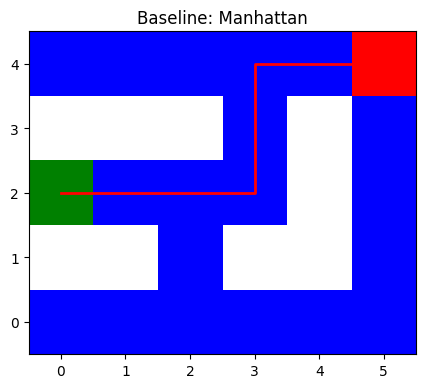

In [2]:
# Case 0: Baseline L1 heuristic
g_pos = locate_char(grid_map, 'B')
h0 = lambda n: L1_dist(n, g_pos)

path_a, cost_a = search_astar(grid_map, h0)
opt_cost = ucs_cost(grid_map)
print("Baseline L1 (Manhattan)")
print("Path:", path_a)
print("Cost:", cost_a)
print("Optimal Cost:", opt_cost, "| Optimal?: ", cost_a == opt_cost)
show_maze(grid_map, path_a, title="Baseline: Manhattan")


1.5 × Manhattan
Path: [(2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5)]
Cost: 7
Optimal Cost: 7 | Optimal? True


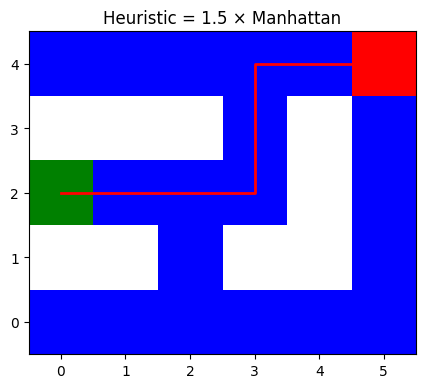

In [3]:
# Case 1: 1.5 × L1
h1 = lambda n: 1.5 * L1_dist(n, locate_char(grid_map, 'B'))

path_b, cost_b = search_astar(grid_map, h1)
opt_cost = ucs_cost(grid_map)
print("1.5 × Manhattan")
print("Path:", path_b)
print("Cost:", cost_b)
print("Optimal Cost:", opt_cost, "| Optimal?", cost_b == opt_cost)
show_maze(grid_map, path_b, title="Heuristic = 1.5 × Manhattan")


Check violation at u->v: (2, 2) -> (2, 3)
h(u) = 6 ; 1 + h(v) = 5 ; Violates? True
Custom inconsistent heuristic
Path: [(2, 0), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5)]
Cost: 7
Optimal Cost: 7 | Optimal? True


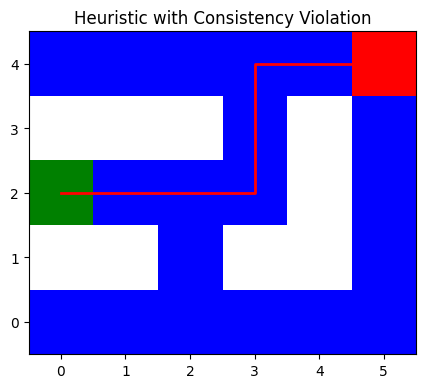

In [4]:
# Case 2: Introduce an explicit consistency violation for one edge.
# We'll create a heuristic that equals L1 except for one pair (u->v)
# where h(u) > 1 + h(v).
g_pos = locate_char(grid_map, 'B')
base_map = { }
for r in range(len(grid_map)):
    for c in range(len(grid_map[0])):
        if grid_map[r][c] != 1:
            base_map[(r,c)] = L1_dist((r,c), g_pos)


cell_u = (2,2)   
cell_v = (2,3)   
#Ensure they are neighbours
assert cell_v in list(get_neighbors(grid_map, *cell_u))


hmap = base_map.copy()
# Force violation: h(u) > 1 + h(v)
hmap[cell_v] = base_map[cell_v]
hmap[cell_u] = hmap[cell_v] + 2  # violates triangle inequality on edge u->v

def h_custom(n):
    return hmap.get(n, base_map.get(n, 0))

# Check the inequality on the chosen edge
print("Check violation at u->v:", cell_u, "->", cell_v)
print("h(u) =", h_custom(cell_u), "; 1 + h(v) =", 1 + h_custom(cell_v), "; Violates?", h_custom(cell_u) > 1 + h_custom(cell_v))

path_c, cost_c = search_astar(grid_map, h_custom)
opt_cost = ucs_cost(grid_map)
print("Custom inconsistent heuristic")
print("Path:", path_c)
print("Cost:", cost_c)
print("Optimal Cost:", opt_cost, "| Optimal?", cost_c == opt_cost)
show_maze(grid_map, path_c, title="Heuristic with Consistency Violation")


In [5]:
# Admissibility checks for each heuristic on this map
g_pos = locate_char(grid_map, 'B')

def check_admissible(grid, h_func):
    
    from collections import deque
    R, C = len(grid), len(grid[0])
    INF = 10**9
    dist = [[INF]*C for _ in range(R)]
    gr, gc = g_pos
    dq = deque([(gr, gc)])
    dist[gr][gc] = 0
    while dq:
        r, c = dq.popleft()
        for nr, nc in get_neighbors(grid, r, c):
            if dist[nr][nc] > dist[r][c] + 1:
                dist[nr][nc] = dist[r][c] + 1
                dq.append((nr, nc))
    ok = True
    violations = []
    for r in range(R):
        for c in range(C):
            if grid[r][c] != 1:
                h = h_func((r,c))
                true_cost = dist[r][c]
                if true_cost == INF:  
                    continue
                if h > true_cost + 1e-9:
                    ok = False
                    violations.append(((r,c), h, true_cost))
    return ok, violations

adm_a, viol_a = check_admissible(grid_map, h0)
adm_b, viol_b = check_admissible(grid_map, h1)
adm_c, viol_c = check_admissible(grid_map, h_custom)

print("Admissible (Manhattan)?", adm_a, "violations:", viol_a[:3])
print("Admissible (1.5×Manhattan)?", adm_b, "violations (first 3):", viol_b[:3])
print("Admissible (custom inconsistent)?", adm_c, "violations (first 3):", viol_c[:3])


Admissible (Manhattan)? True violations: []
Admissible (1.5×Manhattan)? False violations (first 3): [((0, 0), 13.5, 9), ((0, 1), 12.0, 8), ((0, 2), 10.5, 7)]
Admissible (custom inconsistent)? False violations (first 3): [((2, 2), 6, 5)]
